# 1. Описание задачи

 Cоздать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.  
 Под риском понимается вероятность ДТП с любым повреждением транспортного средства.  
 Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска.  
 Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

 ## Исходные данные

* collisions — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
* parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
* vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

# 2. Подключение к базе. Загрузка таблицы sql

In [107]:
# Imports
from category_encoders import MEstimateEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import optuna
from optuna.samplers import TPESampler
import phik
from phik.report import plot_correlation_matrix
from sqlalchemy_schemadisplay import create_schema_graph
from sqlalchemy import MetaData
from sqlalchemy import create_engine
import seaborn as sns

from catboost import CatBoostClassifier, Pool, cv
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import (f1_score, 
                             recall_score, 
                             precision_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay,
                             precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Seed

RS = 3456554 #RandomSeed

In [108]:
# Параметры подключения
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)


# Создание подключения

engine = create_engine(connection_string) 

In [109]:
# Проверим соединение

query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

sample_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


# Первичное исследование таблиц

* Все ли таблицы имеют набор данных;  
* Соответствует ли количество таблиц условию задачи;  
* Имеется ли общий ключ для связи таблиц.  


Для осмотра таблиц используйте sql-запрос.

In [110]:
# Проверим 

query = '''
SELECT *
FROM vehicles
'''

vehicle = pd.read_sql_query(query, con=engine) 

vehicle.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [111]:
# Посмотрим на схему

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

#graph = create_schema_graph(metadata=MetaData(connection_string))

graph = create_schema_graph(metadata=MetaData(connection_string),#.reflect(bind=engine),
    show_datatypes=False,
    show_indexes=False,
    rankdir='LR',
    concentrate=False)


graph.write_png('my_erd2.png')

![](my_erd.png)



Как видим, в БД четыре таблицы, связаных между собой через ключ `case_id`.

Наполнение соответствует описанию в условиях задачи.

Ознакомимся с данными, дабы немного понимать, с чем предстоит иметь дело.

In [112]:
# функция для ознакомления с данными

def first_look(data):
    display(data.info())
    print()
    display(data.describe())
    print()
    print('Дубликатов обнаружено: ', data.duplicated().sum())
    print()
    data.hist(figsize=(25, 15))
    plt.show()
    print()
    print('Размер датасета:', data.shape)
    print()
    print('Пропуски')
    print(data.isna().sum())
    display(data.sample(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


None

,id,party_number,vehicle_age
count,1.021234e+06,1.021234e+06,996652.000000
mean,7.601628e+05,1.609510e+00,5.137088
std,4.386194e+05,6.790946e-01,3.110310
min,1.000000e+00,1.000000e+00,0.000000
25%,3.806942e+05,1.000000e+00,3.000000
50%,7.617625e+05,2.000000e+00,5.000000
75%,1.141348e+06,2.000000e+00,7.000000
max,1.517654e+06,2.700000e+01,161.000000



Дубликатов обнаружено:  0



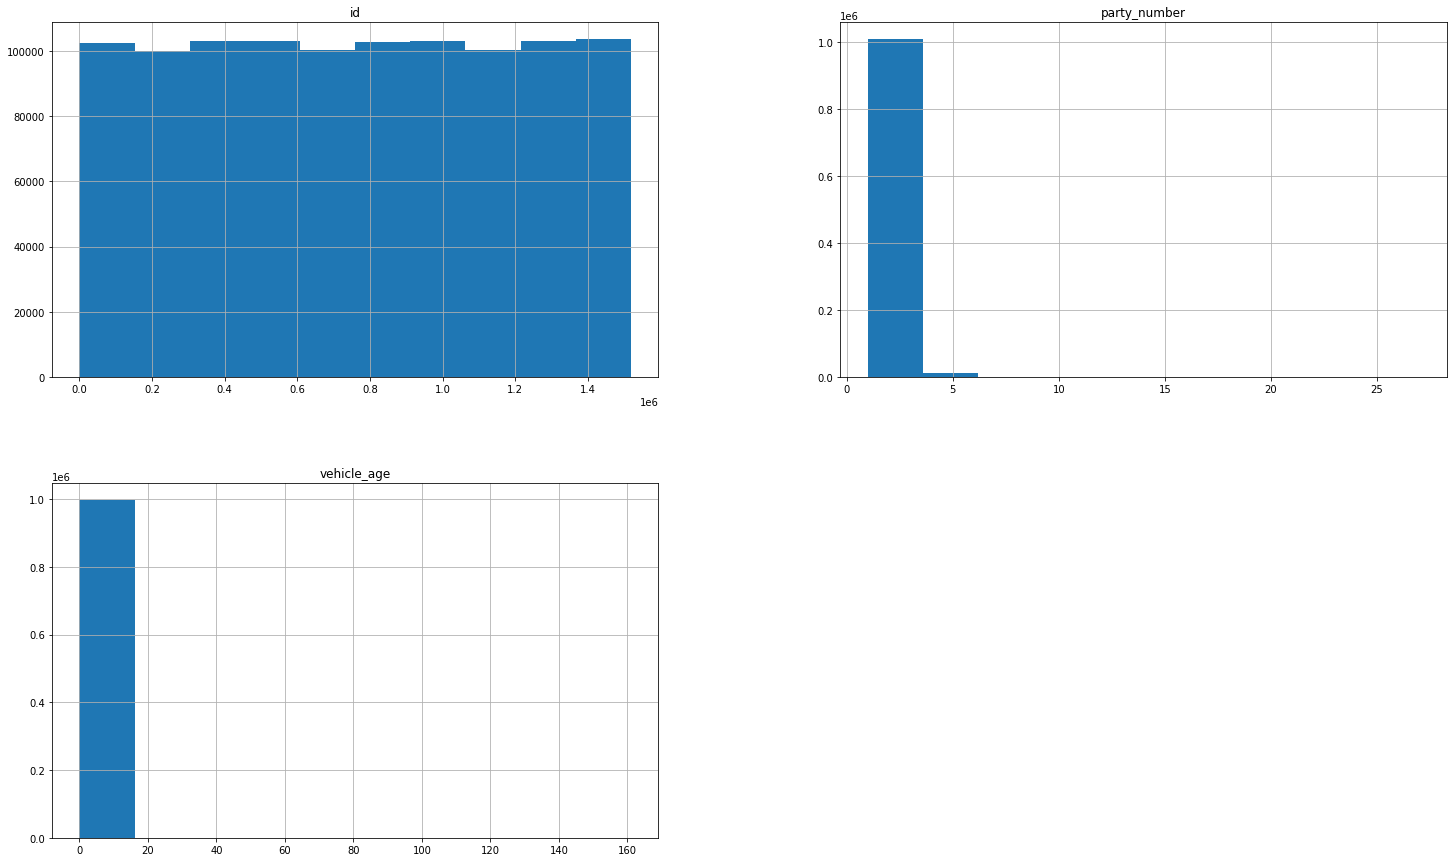


Размер датасета: (1021234, 6)

Пропуски
id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
150476,709256,4842959,1,sedan,auto,7.0
971201,811542,4941212,1,sedan,manual,3.0
203797,43434,4116633,2,coupe,auto,3.0
1013817,1120861,5254957,1,sedan,manual,0.0
964848,762879,4892885,1,sedan,manual,2.0
283611,285404,4379804,2,sedan,auto,3.0
284166,288884,4383205,2,sedan,auto,2.0
412491,1034592,5173453,1,sedan,auto,10.0
892455,242021,4333741,1,sedan,manual,8.0
412360,1033705,5172550,2,sedan,auto,5.0


In [113]:
first_look(vehicle)

In [114]:
vehicle.vehicle_age.value_counts().sort_index(ascending=False)

161.0        17
20.0          2
19.0          6
18.0          1
17.0         31
16.0         96
15.0        673
14.0       4096
13.0      10126
12.0      14947
11.0      27075
10.0      38457
9.0       58255
8.0       77070
7.0       84282
6.0       84362
5.0      105035
4.0      125472
3.0      178550
2.0      106530
1.0       41307
0.0       40262
Name: vehicle_age, dtype: int64

In [115]:
vehicle.vehicle_transmission.value_counts().sort_index(ascending=False)

manual    495332
auto      502243
Name: vehicle_transmission, dtype: int64

In [116]:
vehicle.vehicle_type.value_counts().sort_index(ascending=False)

sedan        488665
other          1194
minivan       43000
hatchback     45595
coupe        442780
Name: vehicle_type, dtype: int64

Есть некорректные (17 авто возрастом 161 год) и пропущенные значения по возрасту, также видны пропуски по типу коробки передач.

In [117]:
# Проверим 

query = '''
SELECT *
FROM collisions
'''

collision = pd.read_sql_query(query, con=engine) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

None

,distance,intersection,party_count
count,1.400000e+06,1.387781e+06,1.400000e+06
mean,6.607115e+02,2.249087e-01,1.966006e+00
std,1.178579e+04,4.175223e-01,6.724457e-01
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.000000e+00,0.000000e+00,2.000000e+00
50%,1.000000e+02,0.000000e+00,2.000000e+00
75%,4.300000e+02,0.000000e+00,2.000000e+00
max,8.363520e+06,1.000000e+00,2.700000e+01



Дубликатов обнаружено:  0



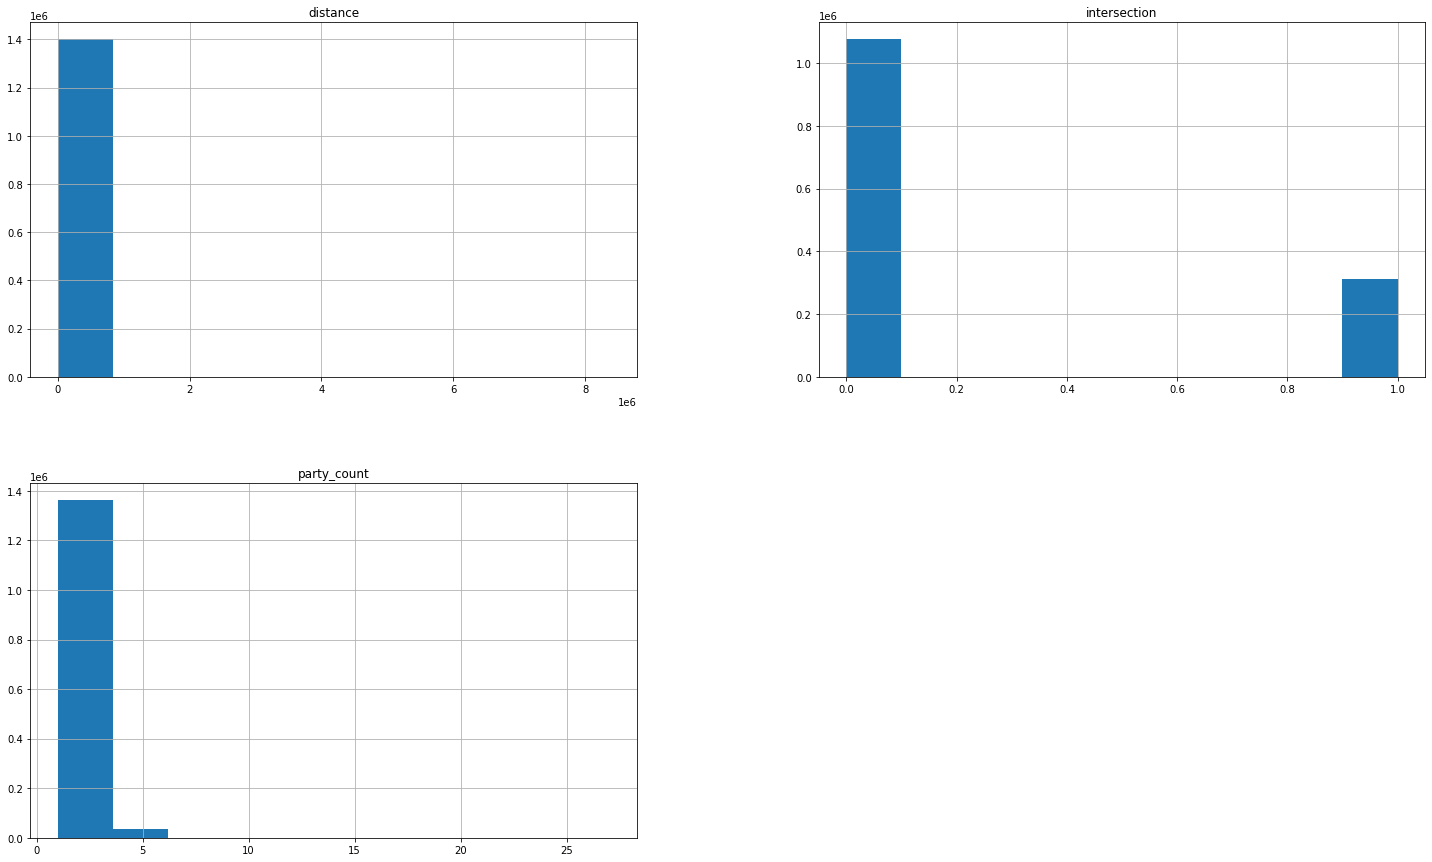


Размер датасета: (1400000, 20)

Пропуски
case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                      340642
intersection                    12219
weather_1                        7259
location_type                  881221
collision_damage                    0
party_count                         0
primary_collision_factor         8166
pcf_violation_category          27954
type_of_collision               11824
motor_vehicle_involved_with      6819
road_surface                    13093
road_condition_1                11988
lighting                         8593
control_device                   8407
collision_date                      0
collision_time                  12308
dtype: int64


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
698670,4649530,1900,los angeles,15.0,south,0.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning,2010-03-19,17:40:00
162573,4697218,3400,sacramento,20.0,east,0.0,raining,None,scratch,1,vehicle code violation,speeding,hit object,fixed object,wet,normal,dark with no street lights,none,2010-04-12,23:59:00
1211220,4129100,1942,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,wrong side of road,other,bicycle,dry,normal,daylight,functioning,2009-01-13,12:15:00
1269436,4767234,3300,riverside,190.0,east,0.0,clear,highway,middle damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,other,daylight,none,2010-06-28,16:57:00
479567,4183950,0109,alameda,528.0,south,0.0,raining,highway,small damage,1,vehicle code violation,improper turning,hit object,fixed object,wet,normal,dark with street lights,none,2009-03-05,02:05:00
1201175,5631614,0701,contra costa,126.0,south,0.0,clear,None,scratch,2,vehicle code violation,improper turning,rear end,parked motor vehicle,None,holes,daylight,none,2012-05-21,15:41:00
962581,5206177,1942,los angeles,300.0,south,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2011-05-12,19:30:00
380405,5463244,0111,alameda,100.0,east,0.0,clear,None,severe damage,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2011-12-01,08:35:00
806879,4891061,3906,san joaquin,0.0,south,NaN,clear,None,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,none,2010-09-25,10:05:00
943329,5166122,4313,santa clara,103.0,south,0.0,cloudy,ramp,small damage,1,vehicle code violation,speeding,hit object,fixed object,wet,normal,daylight,functioning,2011-03-26,08:10:00


In [118]:
first_look(collision)

Также видно небольшое количество пропусков практически по всем столбцам. 

Особенно выделяется `location_type`, где пропущено более половины значений.

In [119]:
query = '''
SELECT *
FROM parties
'''

party = pd.read_sql_query(query, con=engine) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


None

,id,party_number,at_fault,insurance_premium,cellphone_in_use
count,2.752408e+06,2.752408e+06,2.752408e+06,2.347006e+06,2.240771e+06
mean,1.376204e+06,1.598029e+00,4.680000e-01,3.874724e+01,2.045055e-02
std,7.945519e+05,7.236567e-01,4.989750e-01,1.637851e+01,1.415356e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.881028e+05,1.000000e+00,0.000000e+00,2.500000e+01,0.000000e+00
50%,1.376204e+06,1.000000e+00,0.000000e+00,3.600000e+01,0.000000e+00
75%,2.064306e+06,2.000000e+00,1.000000e+00,5.000000e+01,0.000000e+00
max,2.752408e+06,2.700000e+01,1.000000e+00,1.050000e+02,1.000000e+00



Дубликатов обнаружено:  0



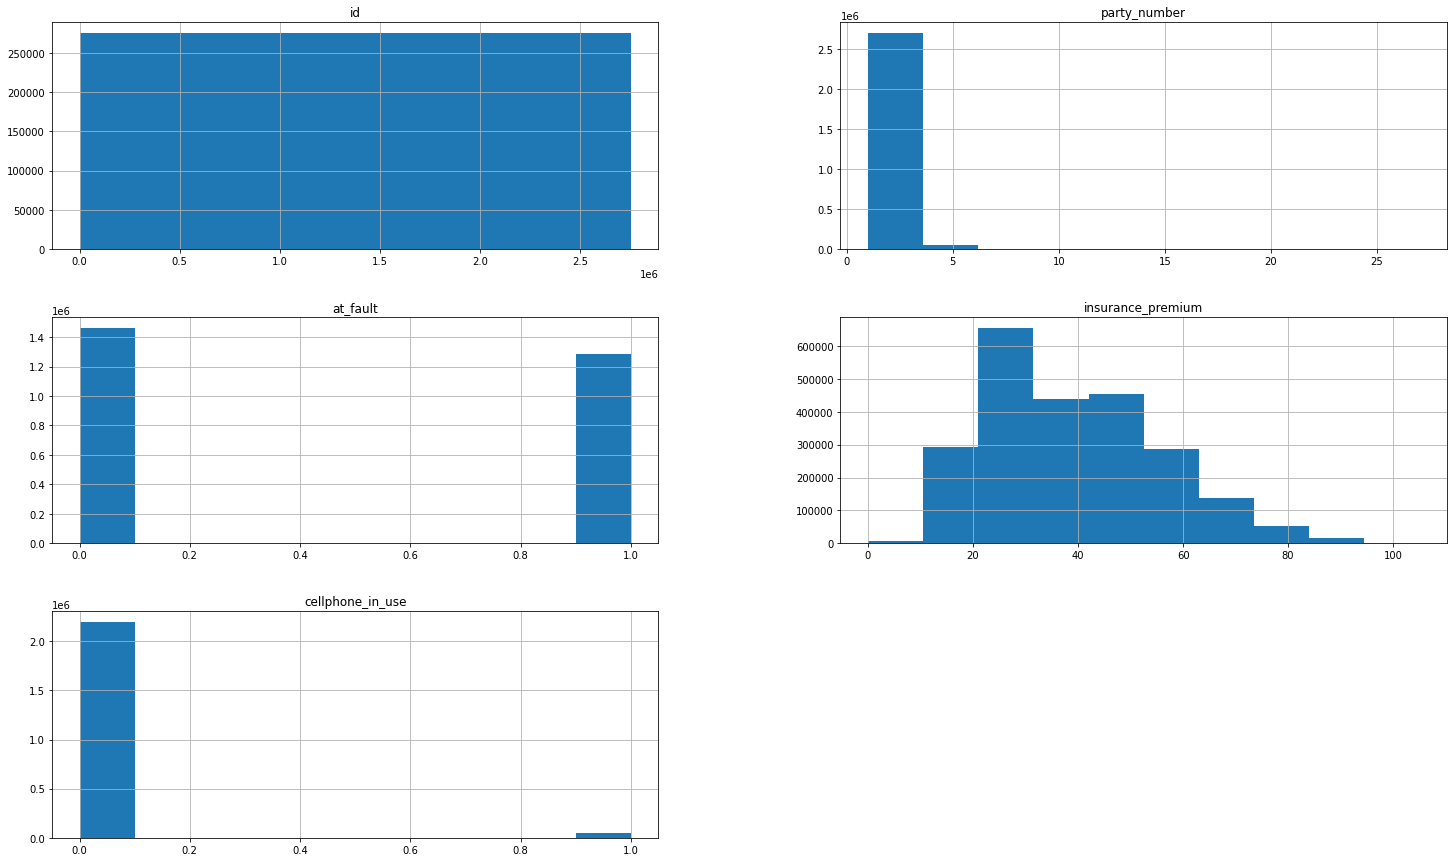


Размер датасета: (2752408, 9)

Пропуски
id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
1016747,434623,4330486,3,car,0,46.0,had not been drinking,None,0.0
1882399,1419503,4911557,2,car,0,19.0,had not been drinking,None,NaN
2039784,1598508,5015593,1,car,1,NaN,impairment unknown,G,0.0
915722,319661,4263574,1,car,1,26.0,"had been drinking, under influence",None,0.0
2121816,1691903,5066994,1,car,0,65.0,"had been drinking, under influence",None,0.0
1011317,428421,4326934,2,car,0,41.0,had not been drinking,None,0.0
1892583,1431256,4917640,1,car,1,36.0,had not been drinking,None,0.0
1286759,742093,4513666,3,car,0,64.0,had not been drinking,None,0.0
15727,130511,4147257,2,road signs,0,49.0,had not been drinking,None,0.0
1569937,1063537,4694739,4,car,0,46.0,had not been drinking,None,0.0


In [120]:
first_look(party)

Аналогично предыдущим таблицам, есть пропуски.

Пропуски в `insurance_premium`, возможно, объясняются отсутствием выплат по страховке (т.е. приравнять пропуски к нулю).

ПРопуски по колонке `party_drug_physical` - вероятно, равны `not applicable`

## Краткий вывод

* Все таблицы имеют набор данных;  
* Количество таблиц соответствует условию задачи;  
* Есть общий ключ для связи таблиц - `case_id`. 

При беглом просмотре данных обнаружено значительное количество пропусков и неадекватные значения.

# 3. Проведите статистический анализ факторов ДТП

1. Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).
* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод.
2. Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. Примеры задач:
* Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
* Найдите самые частые причины ДТП (таблица parties).  


2.1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы.  
2.2. Пропишите порядок решения для двух задач из списка. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:
* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод.

### 3.1. Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).

In [121]:
query = '''
SELECT 
	to_char(collision_date::date, 'Month') AS months,
	COUNT(case_id)
FROM collisions
GROUP BY months
ORDER BY count DESC
'''

crashes_by_months = pd.read_sql_query(query, con=engine) 

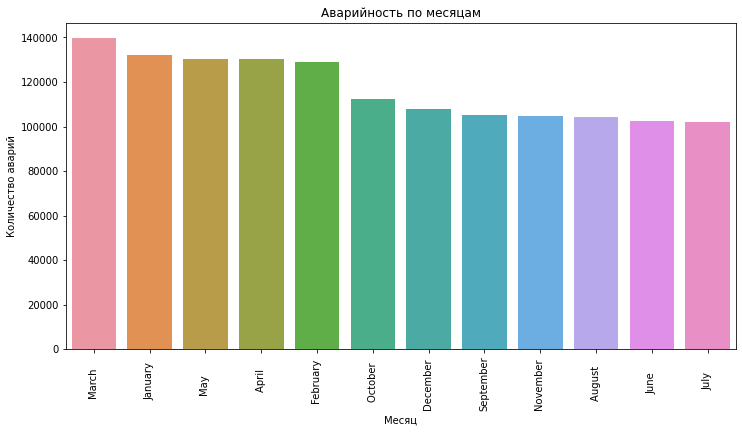

In [122]:
plt.figure(figsize=(12, 6))

sns.barplot(data=crashes_by_months, x='months', y='count')

plt.title('Аварийность по месяцам')
plt.ylabel('Количество аварий')
plt.xlabel('Месяц')
plt.xticks(rotation= 90)

plt.show()


Как видно из графика, аварийность выше всего в первые пять месяцев.

Самая высокая аварийность - в марте, вероятно, из-за смены сезона.

Декабрь, думаю, не попал в топ из-за предддверья праздников - люди ведут себя аккуратнее, чтоб спокойно праздновать, а не решать проблемы.

---

### 3.2. Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. 

Примеры задач:
* Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
* Найдите самые частые причины ДТП (таблица parties).  


#### 3.2.1. Рассчитайте страховую премию, выплаченную виновникам аварии исходя из тяжести повреждений.

Используйте данные за 2009-2011 гг.

Создайте sql-запрос.  
Постройте график.  
Сделайте вывод.

In [123]:
query = '''
SELECT 
	c.collision_damage AS damage_type,
	SUM(p.insurance_premium) AS total_premium,
	EXTRACT('YEAR' FROM c.collision_date::date)::int AS year
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.at_fault = 1 AND EXTRACT('YEAR' FROM c.collision_date::date)::int BETWEEN 2009 AND 2011
GROUP BY year, damage_type

'''

premuim_for_fault = pd.read_sql_query(query, con=engine)#.sort_values(by='total_premium') 
premuim_for_fault

,damage_type,total_premium,year
0,fatal,101814,2009
1,middle damage,1611842,2009
2,scratch,3321639,2009
3,severe damage,303699,2009
4,small damage,6850234,2009
5,fatal,95359,2010
6,middle damage,1589937,2010
7,scratch,3411371,2010
8,severe damage,293858,2010
9,small damage,6851185,2010


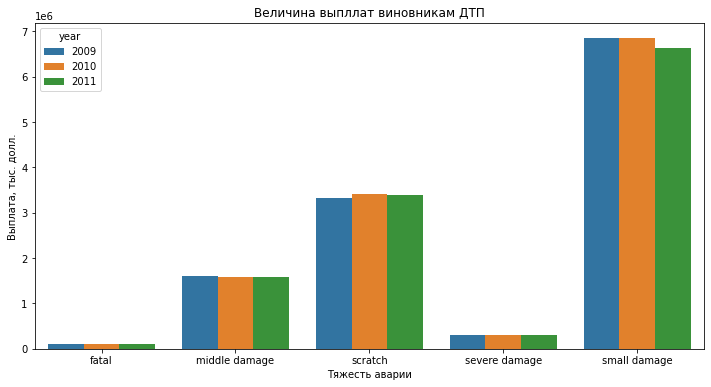

In [124]:
plt.figure(figsize=(12, 6))

sns.barplot(data=premuim_for_fault, x='damage_type', y='total_premium',hue='year')

plt.title('Величина выпллат виновникам ДТП')
plt.ylabel('Выплата, тыс. долл.')
plt.xlabel('Тяжесть аварии')

plt.show()


Как видно из графика, для страховых компаний максимальную нагрузку несут мелкие повреждения.

Из года в год ситуация не меняется.

#### 3.2.2. Рассчитайте средний возраст автомобиля, устроившего ДТП, в зависимости от обстоятельств аварии и тяжести последствий

Вероятно, возраст автомобиля может привести к аварии из-за каких-либо неисправностей.

Создайте sql-запрос.  
Постройте график.  
Сделайте вывод.

In [125]:
query = '''
SELECT 
	DISTINCT c.primary_collision_factor,
	c.collision_damage,
	avg(v.vehicle_age) OVER (PARTITION BY c.primary_collision_factor, c.collision_damage) AS avg_age
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON v.case_id = p.case_id AND p.party_number = v.party_number
WHERE p.at_fault = 1 AND v.vehicle_age <= 20
ORDER BY c.primary_collision_factor, c.collision_damage

'''

avg_year_for_fault = pd.read_sql_query(query, con=engine)#.sort_values(by='total_premium') 
avg_year_for_fault

,primary_collision_factor,collision_damage,avg_age
0,fell asleep,middle damage,6.000000
1,fell asleep,scratch,5.777778
2,fell asleep,severe damage,2.000000
3,fell asleep,small damage,3.500000
4,other improper driving,fatal,6.500000
5,other improper driving,middle damage,5.718462
6,other improper driving,scratch,5.484305
7,other improper driving,severe damage,5.752066
8,other improper driving,small damage,4.546392
9,vehicle code violation,fatal,6.093468


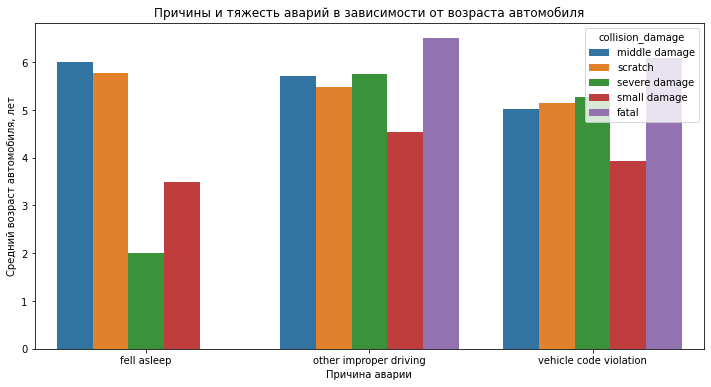

In [126]:
plt.figure(figsize=(12, 6))

sns.barplot(data=avg_year_for_fault, x='primary_collision_factor', y='avg_age',hue='collision_damage')

plt.title('Причины и тяжесть аварий в зависимости от возраста автомобиля')
plt.ylabel('Средний возраст автомобиля, лет')
plt.xlabel('Причина аварии')

plt.show()


Средний возраст практически по всем категориям варьируется в диапазоне 5-6 лет.

#### 3.2.3. Найдите наиболее частые нарушения ПДД в зависимости от состояния водителя

Вероятно, состояние водителя является одной из причин ДТП.

Создайте sql-запрос.  
Постройте график.  
Сделайте вывод.

In [127]:
query = '''
SELECT  distinct
	c.pcf_violation_category,
	p.party_sobriety,
	COUNT(c.pcf_violation_category) OVER (PARTITION BY c.pcf_violation_category, p.party_sobriety)
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.party_sobriety IS NOT NULL AND p.at_fault = 1
'''

violation_category = pd.read_sql_query(query, con=engine)
violation_category

,pcf_violation_category,party_sobriety,count
0,lights,had not been drinking,171
1,automobile right of way,"had been drinking, under influence",340
2,impeding traffic,"had been drinking, impairment unknown",6
3,hazardous parking,"had been drinking, under influence",5
4,hazardous parking,"had been drinking, not under influence",16
...,...,...,...
125,speeding,"had been drinking, under influence",2323
126,following too closely,"had been drinking, not under influence",178
127,dui,not applicable,63
128,impeding traffic,had not been drinking,592


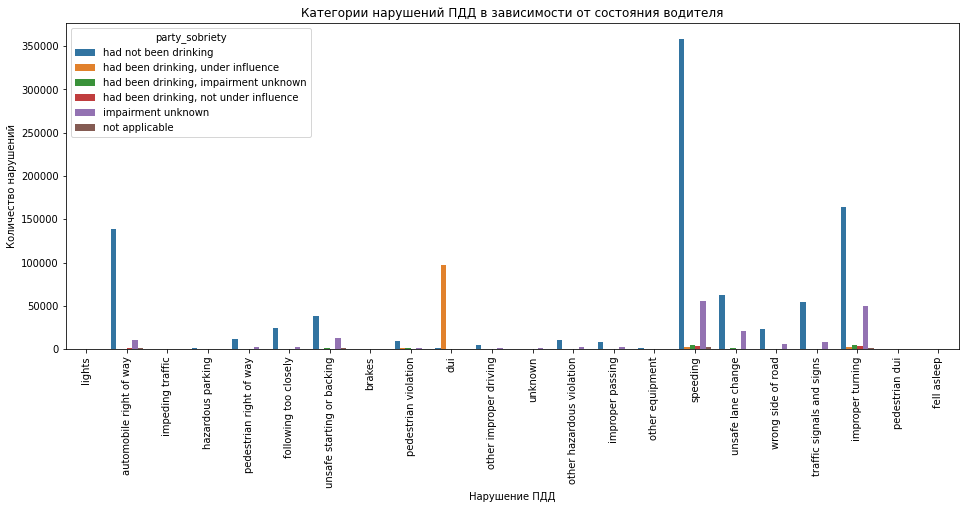

In [128]:
plt.figure(figsize=(16, 6))

sns.barplot(data=violation_category, x='pcf_violation_category', y='count', hue='party_sobriety')

plt.title('Категории нарушений ПДД в зависимости от состояния водителя')
plt.ylabel('Количество нарушений')
plt.xlabel('Нарушение ПДД')
plt.xticks(rotation= 90)

plt.show()


Основное количество нарушений происходит в трезвом состоянии.

Наиболее популярные нарушения - скоростной режим, неправильные повороты и приоритет движения.

#### 3.2.4. Проанализируйте зависимость наступления аварии от состояния дороги и времени суток.

Вероятно, состояние дорог является одной из причин ДТП.

Нужные данные: таблица `collisions`, столбцы `road_surface`, `road_condition_1` и `collision_time`

Создайте sql-запрос.  
Постройте график.  
Сделайте вывод.

#### 3.2.5. Проанализируйте зависимость наступления аварии от состояния дороги для разных типов автомобилей. 

Вероятно, состояние дорог является одной из причин ДТП. Разные типы автомобилей могут с большей вероятностью попадать в аварии на разных типах дорог.

Нужные данные: 
* таблица `collisions`, столбцы `road_surface`, `road_condition_1`;
* таблица `vehicles`, столбeц `vehicle_type`;

Создайте sql-запрос.  
Постройте график.  
Сделайте вывод.



#### 3.2.6. Проанализируйте зависимость наступления аварии от освещенности и времени суток для автомобилей с оборудованием hands-free и без него.

Вероятно, время суток и освещенность является одной из причин ДТП. Возможно, разговоры по телефону без устройств громкой связи чаще приводят к авариям в темное время суток.

Нужные данные: 
* таблица `collisions`, столбцы `lighting` и `collision_time`;
* таблица `parties`, столбeц `cellphone_in_use`;


Создайте sql-запрос.  
Постройте график.  
Сделайте вывод.

# Создайте модель для оценки водительского риска

1. Подготовьте набор данных на основе первичного предположения заказчика:
* Выберите тип виновника — только машина (car). **
* Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
* Для моделирования возьмите данные только за 2012 год.
* Подготовка исходной таблицы должна проводиться с помощью sql-запроса.  
2. Проведите первичный отбор факторов, необходимых для модели.
* Изучите описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП. Будет хорошо, если вы аргументируете свой выбор. 
* Проведите статистическое исследование отобранных факторов.
* По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.
* Если необходимо, категоризируйте исходные данные, проведите масштабирование.
* Подготовьте обучающую и тестовую выборки.

## Подготовка данных

In [129]:
query = '''
SELECT  
	*
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON v.case_id = p.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
	AND c.collision_damage != 'scratch'
	AND EXTRACT(YEAR FROM c.collision_date) = 2012
'''

data_for_model = pd.read_sql_query(query, con=engine)
data_for_model

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5600885,3607,san bernardino,400.0,north,0.0,clear,None,small damage,2,...,43.0,had not been drinking,None,0.0,1465133,5600885,1,sedan,auto,8.0
1,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,...,54.0,had not been drinking,None,0.0,1320506,5449062,2,sedan,manual,10.0
2,5610553,3607,san bernardino,150.0,west,0.0,clear,None,small damage,2,...,27.0,had not been drinking,None,NaN,1473108,5610553,2,sedan,auto,3.0
3,5610588,1942,los angeles,450.0,east,0.0,clear,highway,small damage,2,...,52.0,had not been drinking,None,0.0,1473131,5610588,2,sedan,auto,10.0
4,5620792,3028,orange,2000.0,north,0.0,clear,highway,small damage,2,...,35.0,had not been drinking,None,0.0,1483908,5620792,2,sedan,auto,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5507904,1955,los angeles,2112.0,east,0.0,clear,highway,severe damage,2,...,21.0,had not been drinking,None,0.0,1379953,5507904,1,coupe,manual,3.0
56244,5507937,1913,los angeles,500.0,east,0.0,raining,highway,middle damage,2,...,25.0,had not been drinking,None,0.0,1379980,5507937,2,coupe,manual,4.0
56245,5508004,0108,alameda,0.0,None,1.0,clear,None,severe damage,3,...,73.0,had not been drinking,None,0.0,1380041,5508004,2,coupe,manual,11.0
56246,5508022,5400,tulare,925.0,east,0.0,clear,highway,middle damage,1,...,60.0,"had been drinking, under influence",None,0.0,1380064,5508022,1,coupe,manual,9.0


Отбор признаков для модели.

Из названия колонок сразу удалим все id-образные колонки, для ML-модели они ни к чему.

По остальным разберем нужность и полезность.


In [130]:
columms =[
    'county_city_location',        # нужен, возможно, локация влияет на аварийность - к примеру, горные регионы
    'county_location',             # нужен, возможно, локация влияет на аварийность - к примеру, горные регионы
    'distance',                    # по идее нужен, 
    'direction',                   # нужен, в связи со временем может показывать повышенные риски ДТП (например, ослепление от солнца утром при движении на восток)
    'intersection',                # нужен, перекресток - более аварийное место
    'weather_1',                   # нужен, погода влияет на сложность управления ТС, видимость etc.
    'location_type',               # нужен, влияет на сложность управления ТС
    # 'collision_damage',            # не нужен, до начала поездки не оценить
    # 'primary_collision_factor',    # не нужен, до начала поездки не оценить
    # 'pcf_violation_category',      # не нужен, до начала поездки не оценить
    # 'type_of_collision',           # не нужен, до начала поездки не оценить
    # 'motor_vehicle_involved_with', # не нужен, до начала поездки не оценить
    'road_surface',                # нужен, состояние дороги - важно
    'road_condition_1',            # нужен, состояние дороги - важно
    'lighting',                    # нужен, освещенность дороги - важно
    'control_device',              # нужен ли?
    'collision_date',              # нужен, влияет на управляемость в дороге
    'collision_time',              # нужен, влияет на видимость в дороге
    # 'party_type',                  # не нужен, отобрали только тип `car`
    'at_fault',                    # Целевая переменная
    # 'insurance_premium',           # не нужен, до начала поездки неизвестен
    # 'party_sobriety',              # не нужен, должно быть оценено ДО начала поездки, но возможности нет
    # 'party_drug_physical',         # не нужен, должно быть оценено ДО начала поездки, но возможности нет
    'cellphone_in_use',            # нужен, использование телефона отвлекает от дороги
    'vehicle_type',                # нужен ли? 
    'vehicle_transmission',        # нужен ли? наверное да, технически механика более требовательна к водителю, чем АКПП
    'vehicle_age'                  # нужен, возраст - возможная причина неожиданных поломок, ставших причиной аварии
]

In [131]:
data_for_model = data_for_model[columms]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56248 non-null  object 
 1   county_location       56248 non-null  object 
 2   distance              56248 non-null  float64
 3   direction             43230 non-null  object 
 4   intersection          56073 non-null  float64
 5   weather_1             56080 non-null  object 
 6   location_type         25932 non-null  object 
 7   road_surface          55900 non-null  object 
 8   road_condition_1      55999 non-null  object 
 9   lighting              56094 non-null  object 
 10  control_device        56033 non-null  object 
 11  collision_date        56248 non-null  object 
 12  collision_time        56160 non-null  object 
 13  at_fault              56248 non-null  int64  
 14  cellphone_in_use      51777 non-null  float64
 15  vehicle_type       

None

,distance,intersection,at_fault,cellphone_in_use,vehicle_age
count,5.624800e+04,56073.000000,56248.000000,51777.000000,54554.000000
mean,8.594387e+02,0.221533,0.504427,0.020357,4.856472
std,7.240295e+03,0.415282,0.499985,0.141218,3.234503
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.000000e+00,0.000000,0.000000,0.000000,3.000000
50%,1.350000e+02,0.000000,1.000000,0.000000,4.000000
75%,5.450000e+02,0.000000,1.000000,0.000000,7.000000
max,1.584000e+06,1.000000,1.000000,1.000000,161.000000



Дубликатов обнаружено:  130



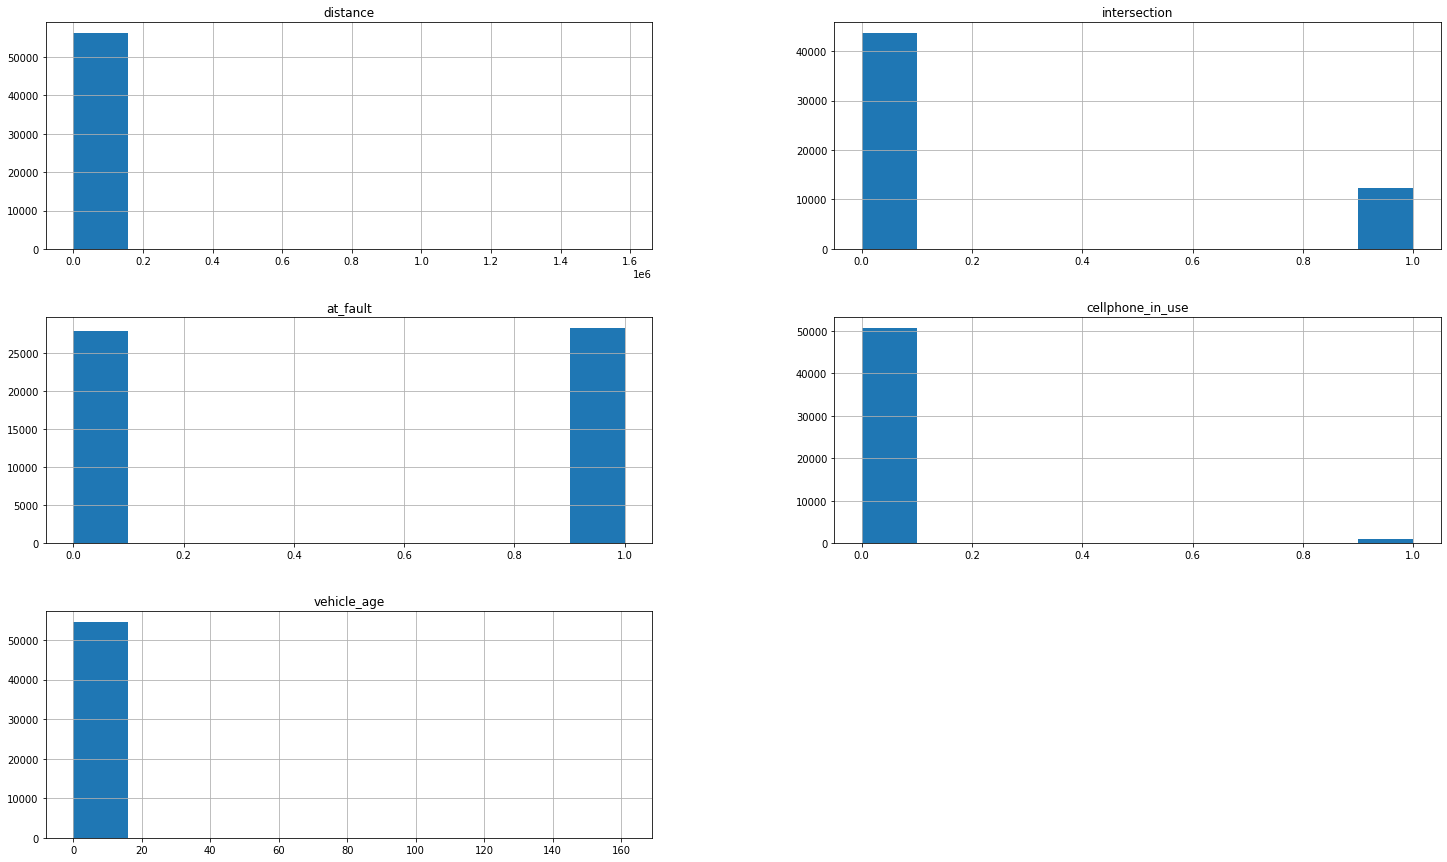


Размер датасета: (56248, 18)

Пропуски
county_city_location        0
county_location             0
distance                    0
direction               13018
intersection              175
weather_1                 168
location_type           30316
road_surface              348
road_condition_1          249
lighting                  154
control_device            215
collision_date              0
collision_time             88
at_fault                    0
cellphone_in_use         4471
vehicle_type                0
vehicle_transmission      859
vehicle_age              1694
dtype: int64


,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
33353,1500,kern,72.0,west,0.0,clear,None,dry,normal,daylight,functioning,2012-05-12,10:00:00,1,0.0,coupe,auto,5.0
2650,1500,kern,528.0,south,0.0,clear,highway,dry,normal,daylight,none,2012-01-10,11:30:00,0,0.0,coupe,manual,6.0
48866,1920,los angeles,500.0,south,0.0,cloudy,highway,dry,normal,daylight,none,2012-04-12,10:07:00,1,0.0,sedan,auto,7.0
5863,4400,santa cruz,1056.0,south,0.0,clear,highway,dry,normal,dark with no street lights,none,2012-04-20,07:20:00,1,0.0,coupe,auto,4.0
47589,1912,los angeles,93.0,west,0.0,cloudy,None,dry,normal,daylight,none,2012-03-31,18:04:00,1,0.0,coupe,manual,8.0
24378,3104,placer,110.0,east,0.0,clear,None,dry,normal,dark with street lights,functioning,2012-01-01,01:32:00,0,0.0,sedan,manual,9.0
54918,1942,los angeles,100.0,north,0.0,clear,highway,dry,normal,daylight,none,2012-04-02,17:20:00,0,0.0,sedan,manual,1.0
36482,2700,monterey,250.0,north,0.0,clear,None,dry,normal,dark with no street lights,functioning,2012-03-11,19:10:00,1,0.0,sedan,manual,2.0
44389,3105,placer,15.0,south,0.0,raining,None,wet,normal,daylight,functioning,2012-04-13,12:47:00,0,0.0,sedan,manual,3.0
45934,3706,san diego,190.0,south,0.0,clear,None,dry,normal,daylight,none,2012-05-24,14:48:00,1,0.0,sedan,manual,4.0


In [132]:
first_look(data_for_model)

### Предобработка датасета для модели

In [133]:
data_for_model.county_location.unique()

array(['san bernardino', 'contra costa', 'los angeles', 'orange',
       'san mateo', 'riverside', 'san diego', 'sacramento', 'san joaquin',
       'yolo', 'santa clara', 'sonoma', 'alameda', 'monterey', 'ventura',
       'tulare', 'fresno', 'marin', 'placer', 'mendocino',
       'san francisco', 'kern', 'stanislaus', 'san luis obispo', 'tehama',
       'san benito', 'santa barbara', 'solano', 'shasta', 'humboldt',
       'santa cruz', 'yuba', 'napa', 'tuolumne', 'madera', 'kings',
       'del norte', 'modoc', 'el dorado', 'lassen', 'merced', 'amador',
       'imperial', 'plumas', 'lake', 'sutter', 'glenn', 'siskiyou',
       'trinity', 'nevada', 'sierra', 'butte', 'mariposa', 'inyo',
       'calaveras', 'mono', 'colusa', 'alpine'], dtype=object)

In [134]:
data_for_model.direction.unique()

array(['north', 'east', 'west', 'south', None], dtype=object)

In [135]:
# Заполним заглушкой
data_for_model.direction = data_for_model.direction.fillna('unknown')

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [136]:
data_for_model.direction.unique()

array(['north', 'east', 'west', 'south', 'unknown'], dtype=object)

In [137]:
data_for_model.intersection.value_counts()

0.0    43651
1.0    12422
Name: intersection, dtype: int64

In [138]:
# Будем считать, что неотмеченный перекресток - не перекресток
data_for_model.intersection = data_for_model.intersection.fillna(0).astype('int')

In [139]:
data_for_model.intersection.unique()

array([0, 1])

In [140]:
data_for_model.weather_1.unique()

array(['clear', 'cloudy', 'raining', 'fog', None, 'snowing', 'other',
       'wind'], dtype=object)

In [141]:
# Заполним пропуски по самому частому значению погоды в день

data_for_model['weather_1'] = data_for_model['weather_1'].fillna(
    data_for_model.groupby(by=['county_location', 'collision_date'])['weather_1'].transform(
        lambda x: x.value_counts().idxmax() if x.value_counts().size else 'unknown'
        )
    )

C:\Users\apple\AppData\Local\Temp\ipykernel_8688\3376408256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['weather_1'] = data_for_model['weather_1'].fillna(


In [142]:
data_for_model.weather_1.unique()

array(['clear', 'cloudy', 'raining', 'fog', 'snowing', 'other', 'unknown',
       'wind'], dtype=object)

In [143]:
data_for_model.location_type.unique()

array([None, 'highway', 'ramp', 'intersection'], dtype=object)

In [144]:
# Заполним пропуски заглушкой, определить самостоятельно не можем
data_for_model.location_type = data_for_model.location_type.fillna('unknown')

In [145]:
data_for_model['road_surface'].unique()

array(['dry', 'wet', None, 'slippery', 'snowy'], dtype=object)

In [146]:
# Заполним пропуски заглушкой, определить самостоятельно не можем
data_for_model.road_surface = data_for_model.road_surface.fillna('unknown')

In [147]:
data_for_model['road_condition_1'].value_counts()

normal            54066
construction       1003
obstruction         248
other               228
holes               222
loose material      128
reduced width        72
flooded              32
Name: road_condition_1, dtype: int64

In [148]:
# Заполним модой 
data_for_model.road_condition_1 = data_for_model.road_condition_1.fillna('normal')

In [149]:
data_for_model['road_condition_1'].isna().sum()
#data_for_model['road_condition_1'].mode()

0

In [150]:
data_for_model['lighting'].value_counts()

daylight                                   38064
dark with street lights                    11017
dark with no street lights                  5109
dusk or dawn                                1769
dark with street lights not functioning      135
Name: lighting, dtype: int64

In [151]:
data_for_model['collision_time'] = pd.to_datetime(data_for_model['collision_time'], format='%H:%M:%S').dt.time
data_for_model['collision_date'] = pd.to_datetime(data_for_model['collision_time'], format='%H:%M:%S').dt.date

C:\Users\apple\AppData\Local\Temp\ipykernel_8688\2829588187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['collision_time'] = pd.to_datetime(data_for_model['collision_time'], format='%H:%M:%S').dt.time
C:\Users\apple\AppData\Local\Temp\ipykernel_8688\2829588187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['collision_date'] = pd.to_datetime(data_for_model['collision_time'], format='%H:%M:%S').dt.date


In [152]:
def lighting_filler(x):
    """"
    Return 'daylight', 'dark' or 'dusk or dawn'
    for  for a range of hours

    """
    if pd.to_datetime(x, format='%H:%M:%S').hour in range(10, 19):
        return 'daylight'
    elif pd.to_datetime(x, format='%H:%M:%S').hour in range(7, 10):
        return 'dusk or dawn'
    elif pd.to_datetime(x, format='%H:%M:%S').hour in range(19, 22):
        return 'dusk or dawn'
    else:
        return 'dark'



In [153]:

data_for_model.loc[data_for_model['lighting'].isna(), 'lighting'] = data_for_model[data_for_model['lighting'].isna()]['collision_time'].apply(lighting_filler)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [154]:
data_for_model['lighting'].isna().sum()

0

In [155]:
data_for_model['control_device'].value_counts()

none               37578
functioning        18310
not functioning      116
obscured              29
Name: control_device, dtype: int64

In [156]:
# Заполним пропуски по большинству, определить самостоятельно не можем
data_for_model['control_device'] = data_for_model['control_device'].fillna('none')

C:\Users\apple\AppData\Local\Temp\ipykernel_8688\2842596095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['control_device'] = data_for_model['control_device'].fillna('none')


In [157]:
data_for_model['control_device'].unique()

array(['none', 'functioning', 'not functioning', 'obscured'], dtype=object)

In [158]:
data_for_model['collision_date'].isna().sum()

88

In [159]:
# Удалим строки без дат, ибо заполнить не можем
data_for_model = data_for_model.query('collision_date.notna()')

In [160]:
data_for_model['cellphone_in_use'].value_counts()

0.0    50644
1.0     1052
Name: cellphone_in_use, dtype: int64

In [161]:
# Заполним пропуски как отсутствие громкой связи в машине
data_for_model['cellphone_in_use'] = data_for_model['cellphone_in_use'].fillna(0)

In [162]:
data_for_model['vehicle_transmission'].value_counts()

manual    29259
auto      26044
Name: vehicle_transmission, dtype: int64

In [163]:
data_for_model['vehicle_transmission'] = data_for_model['vehicle_transmission'].fillna(data_for_model.groupby(by=['vehicle_type'])['vehicle_transmission'].transform(lambda x: x.value_counts().idxmax()))

In [164]:
# Возраст заполним медианным значением
data_for_model['vehicle_age'] = data_for_model['vehicle_age'].fillna(data_for_model['vehicle_age'].median())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56160 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56160 non-null  object 
 1   county_location       56160 non-null  object 
 2   distance              56160 non-null  float64
 3   direction             56160 non-null  object 
 4   intersection          56160 non-null  int32  
 5   weather_1             56160 non-null  object 
 6   location_type         56160 non-null  object 
 7   road_surface          56160 non-null  object 
 8   road_condition_1      56160 non-null  object 
 9   lighting              56160 non-null  object 
 10  control_device        56160 non-null  object 
 11  collision_date        56160 non-null  object 
 12  collision_time        56160 non-null  object 
 13  at_fault              56160 non-null  int64  
 14  cellphone_in_use      56160 non-null  float64
 15  vehicle_type       

None

,distance,intersection,at_fault,cellphone_in_use,vehicle_age
count,5.616000e+04,56160.000000,56160.000000,56160.000000,56160.000000
mean,8.574230e+02,0.220940,0.503900,0.018732,4.830253
std,7.243228e+03,0.414884,0.499989,0.135579,3.189261
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.000000e+00,0.000000,0.000000,0.000000,3.000000
50%,1.340000e+02,0.000000,1.000000,0.000000,4.000000
75%,5.400000e+02,0.000000,1.000000,0.000000,7.000000
max,1.584000e+06,1.000000,1.000000,1.000000,161.000000



Дубликатов обнаружено:  178



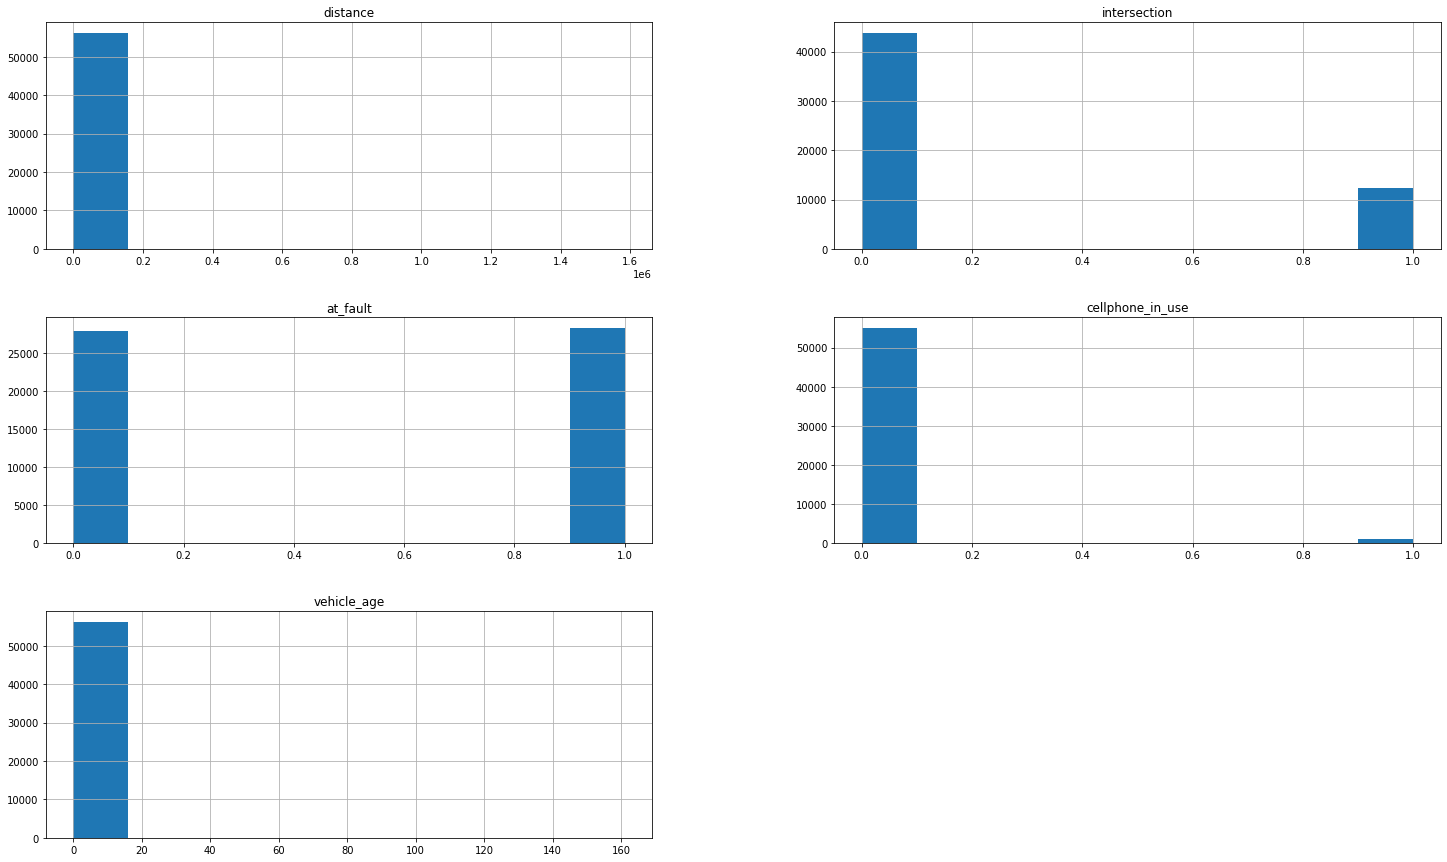


Размер датасета: (56160, 18)

Пропуски
county_city_location    0
county_location         0
distance                0
direction               0
intersection            0
weather_1               0
location_type           0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
collision_date          0
collision_time          0
at_fault                0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64


,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
5215,3710,san diego,0.0,unknown,1,clear,unknown,dry,normal,dark with street lights,none,1900-01-01,18:23:00,0,0.0,coupe,manual,4.0
47765,3900,san joaquin,8976.0,east,0,clear,highway,dry,normal,dark with no street lights,none,1900-01-01,21:10:00,0,0.0,coupe,manual,6.0
29018,1955,los angeles,2640.0,east,0,cloudy,highway,wet,normal,daylight,none,1900-01-01,13:30:00,0,0.0,sedan,auto,3.0
41785,3400,sacramento,360.0,east,0,clear,unknown,dry,normal,dark with street lights,functioning,1900-01-01,19:30:00,0,0.0,sedan,auto,4.0
51703,4803,solano,400.0,east,0,clear,unknown,dry,normal,dark with street lights,none,1900-01-01,22:33:00,0,0.0,sedan,auto,4.0
55959,1942,los angeles,0.0,unknown,1,clear,unknown,dry,normal,dark with street lights,functioning,1900-01-01,20:15:00,0,0.0,coupe,manual,7.0
14880,1920,los angeles,60.0,east,0,clear,unknown,dry,normal,daylight,functioning,1900-01-01,18:42:00,0,0.0,coupe,manual,4.0
34016,3014,orange,48.0,south,0,clear,unknown,dry,normal,daylight,none,1900-01-01,17:52:00,1,0.0,sedan,manual,0.0
863,1985,los angeles,0.0,unknown,1,clear,unknown,dry,normal,daylight,functioning,1900-01-01,16:40:00,0,0.0,sedan,auto,3.0
46175,4116,san mateo,1056.0,south,0,clear,highway,dry,normal,dark with no street lights,none,1900-01-01,19:30:00,0,0.0,sedan,manual,1.0


In [165]:
first_look(data_for_model)

В целом почти все хорошо, замечено три проблемы. 

1. Появились дубликаты.
2. Неадекватные значения возраста машин.
3. Тип данных в `county_city_location`, `cellphone_in_use` и `vehicle_age`

Поправим это.

In [166]:
data_for_model.drop_duplicates(inplace=True)

data_for_model = data_for_model.query('vehicle_age <= 20')

data_for_model['county_city_location'] = data_for_model['county_city_location'].astype('int')
data_for_model['cellphone_in_use'] = data_for_model['cellphone_in_use'].astype('int')
data_for_model['vehicle_age'] = data_for_model['vehicle_age'].astype('int')
data_for_model['distance'] = data_for_model['distance'].astype('int')

In [167]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55980 entries, 0 to 56247
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   county_city_location  55980 non-null  int32 
 1   county_location       55980 non-null  object
 2   distance              55980 non-null  int32 
 3   direction             55980 non-null  object
 4   intersection          55980 non-null  int32 
 5   weather_1             55980 non-null  object
 6   location_type         55980 non-null  object
 7   road_surface          55980 non-null  object
 8   road_condition_1      55980 non-null  object
 9   lighting              55980 non-null  object
 10  control_device        55980 non-null  object
 11  collision_date        55980 non-null  object
 12  collision_time        55980 non-null  object
 13  at_fault              55980 non-null  int64 
 14  cellphone_in_use      55980 non-null  int32 
 15  vehicle_type          55980 non-null

#### Дополнительные признаки

In [168]:
data_for_model['collision_date'] = pd.to_datetime(data_for_model['collision_date'], format='%Y-%m-%d').dt.round('1d')
data_for_model['collision_time'] = pd.to_datetime(data_for_model['collision_time'], format='%H:%M:%S').dt.round('H')


data_for_model['collision_month'] = data_for_model['collision_date'].dt.month
data_for_model['collision_day'] = data_for_model['collision_date'].dt.day

data_for_model['collision_hour'] = data_for_model['collision_time'].dt.hour



In [169]:
data_for_model

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,...,collision_date,collision_time,at_fault,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_month,collision_day,collision_hour
0,3607,san bernardino,400,north,0,clear,unknown,dry,normal,dark with street lights,...,1900-01-01,1900-01-01 22:00:00,1,0,sedan,auto,8,1,1,22
1,708,contra costa,21,east,0,clear,unknown,dry,normal,dark with street lights,...,1900-01-01,1900-01-01 02:00:00,0,0,sedan,manual,10,1,1,2
2,3607,san bernardino,150,west,0,clear,unknown,dry,normal,daylight,...,1900-01-01,1900-01-01 17:00:00,0,0,sedan,auto,3,1,1,17
3,1942,los angeles,450,east,0,clear,highway,dry,normal,daylight,...,1900-01-01,1900-01-01 17:00:00,0,0,sedan,auto,10,1,1,17
4,3028,orange,2000,north,0,clear,highway,dry,normal,daylight,...,1900-01-01,1900-01-01 11:00:00,0,0,sedan,auto,2,1,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,1955,los angeles,2112,east,0,clear,highway,dry,normal,daylight,...,1900-01-01,1900-01-01 08:00:00,1,0,coupe,manual,3,1,1,8
56244,1913,los angeles,500,east,0,raining,highway,wet,normal,daylight,...,1900-01-01,1900-01-01 13:00:00,0,0,coupe,manual,4,1,1,13
56245,108,alameda,0,unknown,1,clear,unknown,dry,construction,daylight,...,1900-01-01,1900-01-01 12:00:00,0,0,coupe,manual,11,1,1,12
56246,5400,tulare,925,east,0,clear,highway,dry,normal,dark with no street lights,...,1900-01-01,1900-01-01 23:00:00,1,0,coupe,manual,9,1,1,23


### Подготовка выборок для модели

In [170]:
columns=data_for_model.columns
columns



Index(['county_city_location', 'county_location', 'distance', 'direction',
       'intersection', 'weather_1', 'location_type', 'road_surface',
       'road_condition_1', 'lighting', 'control_device', 'collision_date',
       'collision_time', 'at_fault', 'cellphone_in_use', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'collision_month',
       'collision_day', 'collision_hour'],
      dtype='object')

In [171]:
numeric_cols = ['county_city_location', 'distance', 'intersection', 'cellphone_in_use', 'collision_month', 'collision_day', 'collision_hour']

ohe_cols = ['direction', 'weather_1', 'location_type', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'vehicle_type', 'vehicle_transmission', 'county_location']


In [172]:
X = data_for_model[numeric_cols + ohe_cols] # + me_cols]
y = data_for_model['at_fault']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=.8, 
    random_state=RS 
)

In [173]:
print('train:', X_train.shape[0], '; доля от всей выборки:', round(X_train.shape[0] / X.shape[0], 2) * 100, '%')

print('test:', X_train.shape[0], '; доля от всей выборки:', round(X_test.shape[0] / X.shape[0], 2) * 100, '%')

train: 44784 ; доля от всей выборки: 80.0 %
test: 44784 ; доля от всей выборки: 20.0 %


In [174]:
num_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
ohe_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
me_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
me_encoder = MEstimateEncoder()

pipe_num = Pipeline([('imputer', num_imputer), ('scaler', std_scaler)])

pipe_ohe = Pipeline([('ohe_imputer', ohe_imputer), ('ohe_encoder', ohe_encoder)])

#pipe_me = Pipeline([('me_imputer', me_imputer), ('me_encoder', me_encoder)])

col_transformer = ColumnTransformer([('num_preproc', pipe_num, numeric_cols),
                                     ('ohe_preproc', pipe_ohe, ohe_cols),
                                     #('me_prerpoc', pipe_me, me_cols)
                                    ])

fin_pipe = Pipeline([('full_prep', col_transformer)])

In [175]:
X_train_transformed = fin_pipe.fit_transform(X_train)

X_test_transformed = fin_pipe.transform(X_test)

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [176]:
ohe_features = fin_pipe.named_steps['full_prep'].transformers_[1][1].named_steps['ohe_encoder'].get_feature_names_out(ohe_cols)

#me_features = me_cols

num_features = fin_pipe.named_steps['full_prep'].transformers_[0][1].named_steps['scaler'].get_feature_names_out(numeric_cols)

In [177]:
print(ohe_features, '\n')
#print(me_features, '\n')
print(num_features, '\n')

['direction_east' 'direction_north' 'direction_south' 'direction_unknown'
 'direction_west' 'weather_1_clear' 'weather_1_cloudy' 'weather_1_fog'
 'weather_1_other' 'weather_1_raining' 'weather_1_snowing'
 'weather_1_unknown' 'weather_1_wind' 'location_type_highway'
 'location_type_intersection' 'location_type_ramp' 'location_type_unknown'
 'road_surface_dry' 'road_surface_slippery' 'road_surface_snowy'
 'road_surface_unknown' 'road_surface_wet' 'road_condition_1_construction'
 'road_condition_1_flooded' 'road_condition_1_holes'
 'road_condition_1_loose material' 'road_condition_1_normal'
 'road_condition_1_obstruction' 'road_condition_1_other'
 'road_condition_1_reduced width' 'lighting_dark'
 'lighting_dark with no street lights' 'lighting_dark with street lights'
 'lighting_dark with street lights not functioning' 'lighting_daylight'
 'lighting_dusk or dawn' 'control_device_functioning'
 'control_device_none' 'control_device_not functioning'
 'control_device_obscured' 'vehicle_type_c

In [178]:
pd.DataFrame(X_train_transformed)

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
0,2.122998,-0.033676,-0.529790,-0.139594,0.0,0.0,0.268543,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.424376,0.089907,-0.529790,-0.139594,0.0,0.0,-0.799286,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.680500,-0.108404,-0.529790,7.163641,0.0,0.0,-2.223058,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.683588,-0.109032,-0.529790,-0.139594,0.0,0.0,0.268543,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.116094,0.023594,-0.529790,-0.139594,0.0,0.0,-2.401030,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44779,-0.701347,-0.094212,-0.529790,-0.139594,0.0,0.0,-0.977258,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44780,-2.119696,-0.040583,-0.529790,-0.139594,0.0,0.0,-0.265372,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44781,0.128662,-0.083913,-0.529790,-0.139594,0.0,0.0,0.268543,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44782,-0.729914,-0.058794,-0.529790,7.163641,0.0,0.0,1.336372,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Краткий вывод

Выгружены необходимые для решения задачи данные.

Отобраны признаки, необходимые для обучения моделей.

Проведена предобработка данных:
* заполнены пропуски;
* удалены/заменены некорректные значения;
* данные приведены к соответствующим типам.

Подготовлены тренировочная и тестовая выборки для обучения моделей.

Построен пайплан для кодирования и масштабирования данных.

# Обучение моделей

## Выбор метрики

Разумным выбором для поставленной задачи (задачи бинарной классификации) является F1-мера.

* TP - число аварий, которые модель предсказала верно. В таком случае клиенту будет либо перестроен маршрут с меншьим шансов попасть в ДТП, либо выдан запрет на пользование автомобилем. Нужно макcимизировать.

* TN - число поездок без аварий, которые модель предсказала верно. В таком случае клиент спокойно доедет до своего пункта назначения. Также нужно максимизировать.

* FP - число поездок без аварий, которые модель предсказала аварийными. В таком случае компания получает раздражденного запретом поездки клиента. Нужно минимизировать этот параметр.

* FN - число аварий, которые модель предсказала безаварийными. В этом случае компания несет убытки на ремонт машины. Также нужно минимизировать.

Следовательно, как метрики можно использовать полноту (Recall) и точность (Precision), что и приводит к выбору F1-score.

## Обучим логистическую регрессию

In [74]:
model = LogisticRegression(random_state=RS, max_iter=10000)

model.fit(X_train_transformed, y_train)

score = cross_val_score(model, X_train_transformed, y_train, scoring='f1')

print('F1-score:', score.mean())

F1-score: 0.5913252566355313


Подберем гиперпараметры с помощью Optuna

In [179]:
def objective_LR(trial):
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    tol = trial.suggest_float("tol", 0.0001, 0.01, log=True)
    C = trial.suggest_float("C", 1.0, 10.0, log=True)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

    classifier = LogisticRegression(random_state=RS, 
                                    max_iter=5000,
                                    penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    fit_intercept=intercept,
                                    solver=solver,
                                    multi_class='auto',
                                   )
    
    classifier.fit(X_train_transformed, y_train)

    scores = cross_val_score(classifier, X_train_transformed, y_train, scoring='f1')
    
    return scores.mean()

In [180]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RS)

study_LR = optuna.create_study(study_name="LogisticRegression", direction="maximize", sampler=sampler)
study_LR.optimize(objective_LR, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [181]:
print('Number of finished trials: ', len(study_LR.trials))
print('Best trial:')
trial = study_LR.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.5910363900352419
  Params: 
    penalty: l2
    tol: 0.000609171940979124
    C: 6.16833569710539
    fit_intercept: True
    solver: saga


In [184]:
model_LR = LogisticRegression(**study_LR.best_params, multi_class="auto", random_state=RS)

model_LR.fit(X_train_transformed, y_train)


# Метрики 
best_f1_LR = trial.value
best_recall_LR = cross_val_score(model_LR, X_train_transformed, y_train, scoring='recall').mean()
best_precision_LR = cross_val_score(model_LR, X_train_transformed, y_train, scoring='precision').mean()

print(f'Logistic Regression F1-score:  {best_f1_LR}')
print(f'Logistic Regression Recall:    {best_recall_LR}')
print(f'Logistic Regression Precision: {best_precision_LR}')

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression F1-score:  0.5910363900352419
Logistic Regression Recall:    0.5667343978048496
Logistic Regression Precision: 0.6151410663008935


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Обучим случайный лес

In [185]:
model_RF = RandomForestClassifier(random_state=RS)

model_RF.fit(X_train_transformed, y_train)


score = cross_val_score(model_RF, X_train_transformed, y_train, scoring='f1')

print('F1-score:', score.mean())

F1-score: 0.5369925957424131


Подберем гиперпараметры с помощью Optuna

In [186]:
def objective_RF(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini', 'log_loss'])
    bootstrap = trial.suggest_categorical('bootstrap',[True, False])
    max_depth = trial.suggest_int('max_depth', 1, 100)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 2000)
    
    classifier = RandomForestClassifier(random_state=RS,
                                        bootstrap = bootstrap, 
                                        criterion = criterion,
                                        max_depth = max_depth, 
                                        max_features = max_features,
                                        max_leaf_nodes = max_leaf_nodes,
                                        n_estimators=n_estimators,
                                        n_jobs=2)
    
    
    classifier.fit(X_train_transformed, y_train)
    scores = cross_val_score(classifier, X_train_transformed, y_train, scoring='f1')
    
    return scores.mean()

In [187]:
study_RF = optuna.create_study(study_name="RandomForest", direction="maximize", sampler=sampler)
study_RF.optimize(objective_RF, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [188]:
print('Number of finished trials: ', len(study_LR.trials))
print('Best trial:')
trial = study_RF.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  100
Best trial:
  Value:  0.6311821819390353
  Params: 
    criterion: gini
    bootstrap: False
    max_depth: 1
    max_features: log2
    max_leaf_nodes: 8442
    n_estimators: 1912


In [189]:
model_RF = RandomForestClassifier(**study_RF.best_params, random_state=RS)

model_RF.fit(X_train_transformed, y_train)

# Метрики 
best_f1_RF = trial.value
best_recall_RF = cross_val_score(model_RF, X_train_transformed, y_train, scoring='recall')
best_precision_RF = cross_val_score(model_RF, X_train_transformed, y_train, scoring='precision')

print(f'Random Forest F1-score:  {best_f1_RF}')
print(f'Random Forest Recall:    {best_recall_RF}')
print(f'Random Forest Precision: {best_precision_RF}')


Random Forest F1-score:  0.6311821819390353
Random Forest Recall:    [0.71025358 0.70033076 0.70798412 0.70952801 0.72011469]
Random Forest Precision: [0.57292778 0.56937971 0.56904804 0.56428697 0.56625043]


## Обучим CatBoost

Проверим качество на кодированных данных

In [84]:
model_CB_enc = CatBoostClassifier(loss_function='Logloss', random_state=RS, verbose=False)

model_CB_enc.fit(X_train_transformed, y_train)


score = cross_val_score(model_CB_enc, X_train_transformed, y_train, scoring='f1')

print('F1-score:', score.mean())

F1-score: 0.5578687715836211


Подберем гиперпараметры с помощью Optuna

In [85]:
def objective_CB_enc(trial):
    iterations = trial.suggest_int('iterations', 400, 800)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
    random_strength = trial.suggest_float('random_strength', 1e-8, 10.0, log=True)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 10.0)
    od_type = trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    od_wait = trial.suggest_int('od_wait', 10, 50)
    verbose = False
    

    classifier = CatBoostClassifier(random_state=RS,
                                    loss_function='Logloss', 
                                    iterations=iterations,
                                    learning_rate=learning_rate,
                                    depth=depth,
                                    l2_leaf_reg=l2_leaf_reg,
                                    bootstrap_type=bootstrap_type,
                                    random_strength=random_strength,
                                    bagging_temperature=bagging_temperature,
                                    od_type=od_type,
                                    od_wait=od_wait,
                                    verbose=False
    )

    classifier.fit(X_train_transformed, y_train)
    
    scores = cross_val_score(classifier, X_train_transformed, y_train, scoring='f1')
    
    return scores.mean()

In [86]:
study_CB_enc = optuna.create_study(study_name="catboost_enc", direction="maximize", sampler=sampler)
study_CB_enc.optimize(objective_CB_enc, n_trials=150, show_progress_bar=True)

  0%|          | 0/150 [00:00<?, ?it/s]

In [87]:
print('Number of finished trials: ', len(study_CB_enc.trials))
print('Best trial:')
trial = study_CB_enc.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  150
Best trial:
  Value:  0.5826374053214216
  Params: 
    iterations: 773
    learning_rate: 0.03457675320065588
    depth: 4
    l2_leaf_reg: 1.7656098210850556e-05
    bootstrap_type: Bayesian
    random_strength: 2.722671988473844e-08
    bagging_temperature: 7.471102131130359
    od_type: Iter
    od_wait: 48


In [88]:
model_CB_enc = CatBoostClassifier(**study_CB_enc.best_params, random_state=RS, verbose=False)

model_CB_enc.fit(X_train_transformed, y_train)

# Метрики 
best_f1_CB_enc = trial.value
best_recall_CB_enc = cross_val_score(model_CB_enc, X_train_transformed, y_train, scoring='recall')
best_precision_CB_enc = cross_val_score(model_CB_enc, X_train_transformed, y_train, scoring='precision')

print(f'CatBoost encoded F1-score:  {best_f1_CB_enc}')
print(f'CatBoost encoded Recall:    {best_recall_CB_enc}')
print(f'CatBoost encoded Precision: {best_precision_CB_enc}')


CatBoost F1-score on Train: 0.614951768488746
CatBoost F1-score on Valid: 0.6161128974633798
CatBoost F1-score on Test: 0.6068238656663094


Проверим на некодированных данных.

In [89]:
cb_categories = ohe_cols # + me_cols

In [90]:
model_CB = CatBoostClassifier(loss_function='Logloss', random_state=RS, verbose=False, cat_features=cb_categories)

model_CB.fit(X_train, y_train)

predictions = model_CB.predict(X_valid)

score = f1_score(y_valid, predictions)

print('F1-score:', score)

F1-score: 0.5646115288220552


In [91]:
def objective_CB(trial):
    iterations = trial.suggest_int('iterations', 400, 800)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True)
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian'])
    random_strength = trial.suggest_float('random_strength', 1e-8, 10.0, log=True)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 10.0)
    od_type = trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    od_wait = trial.suggest_int('od_wait', 10, 50)
    verbose = False
    

    classifier = CatBoostClassifier(random_state=RS,
                                    cat_features=cb_categories,
                                    loss_function='Logloss', 
                                    iterations=iterations,
                                    learning_rate=learning_rate,
                                    depth=depth,
                                    l2_leaf_reg=l2_leaf_reg,
                                    bootstrap_type=bootstrap_type,
                                    random_strength=random_strength,
                                    bagging_temperature=bagging_temperature,
                                    od_type=od_type,
                                    od_wait=od_wait,
                                    verbose=False
    )

    classifier.fit(X_train, y_train)
    
    scores = cross_val_score(classifier, X_train, y_train, scoring='f1')
    
    return scores.mean()

In [92]:
study_CB = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study_CB.optimize(objective_CB, n_trials=150)

In [93]:
print('Number of finished trials: ', len(study_CB.trials))
print('Best trial:')
trial = study_CB.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')



Number of finished trials:  150
Best trial:
  Value:  0.5810901427339784
  Params: 
    iterations: 495
    learning_rate: 0.01073098567799106
    depth: 4
    l2_leaf_reg: 0.05654852656600377
    bootstrap_type: Bayesian
    random_strength: 0.002628501215255411
    bagging_temperature: 9.5037367106254
    od_type: IncToDec
    od_wait: 30


In [94]:
model_CB = CatBoostClassifier(**study_CB.best_params, random_state=RS, verbose=False, cat_features=cb_categories)

model_CB.fit(X_train, y_train)

# Метрики 
best_f1_CB = trial.value
best_recall_CB = cross_val_score(model_CB, X_train_transformed, y_train, scoring='recall')
best_precision_CB = cross_val_score(model_CB, X_train_transformed, y_train, scoring='precision')

print(f'CatBoost F1-score:  {best_f1_CB}')
print(f'CatBoost Recall:    {best_recall_CB}')
print(f'CatBoost Precision: {best_precision_CB}')


CatBoost F1-score on Train: 0.6063475050613314
CatBoost F1-score on Valid: 0.6094140764558771
CatBoost F1-score on Test: 0.6086102179349768


In [95]:
pd.DataFrame(data=[
    [best_f1_LR, best_f1_RF, best_f1_CB_enc, best_f1_CB],
    [best_recall_LR, best_recall_RF, best_recall_CB_enc, best_recall_CB],
    [best_precision_LR, best_precision_RF, best_precision_CB_enc, best_precision_CB],
    ],
    columns=['LinearRegression', 'RandomForest', 'CatBoost_encoded', 'CatBoost'], index=['F1-score', 'Recall', 'Precision'])

,LinearRegression,RandomForest,CatBoost_encoded,CatBoost
F1-score,0.597686,0.630528,0.575097,0.581391
Recall,0.573872,0.701340,0.525212,0.536495
Precision,0.623563,0.572704,0.635452,0.634487


## Сделайте общий вывод по модели  
Кратко опишите лучшую модель.  
Сделайте вывод: насколько возможно создание адекватной системы оценки риска при выдаче авто?  
Какие факторы ещё необходимо собирать, чтобы улучшить модель?

Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.  
Проанализируйте важность основных факторов, влияющих на вероятность ДТП.  
Для одного из выявленных важных факторов проведите дополнительное исследование:
* Покажите график зависимости фактора и целевой переменной.
* Предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.

## Краткий вывод

Были обучены три модели-классификатора:

* логистическая регрессия (LogisticRegression);
* случайный лес (RandomForestClassifier);
* CatBoostClassifier.

Выбрана метрика оценки качества модели - F1-мера.

Лучший результат показал RandomForest с показателем F1-меры в 0.6305.

На мой взгляд, при текущих данных точность модели недостаточна для запуска.

Возможно, улучшить прогноз могли бы данные:
* непосредственно о водителе (возраст, пол, стаж, семейное положение etc);
* более подробные данные по автомобилям (бренд, марка, возраст, мощность etc);
* взять более широкий временной диапазон (возможно, данных за год недостаточно).

In [191]:
cm = confusion_matrix(y_test, model_RF.predict(X_test_transformed))
cm

array([[2421, 3164],
       [1628, 3983]], dtype=int64)

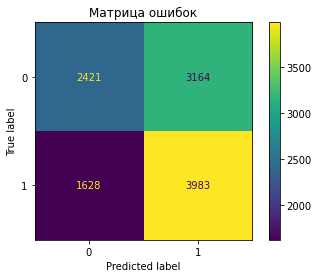

In [192]:
ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, model_RF.predict(X_test_transformed)), 
        display_labels=model_CB.classes_
    ).plot()

plt.title('Матрица ошибок')
plt.show()

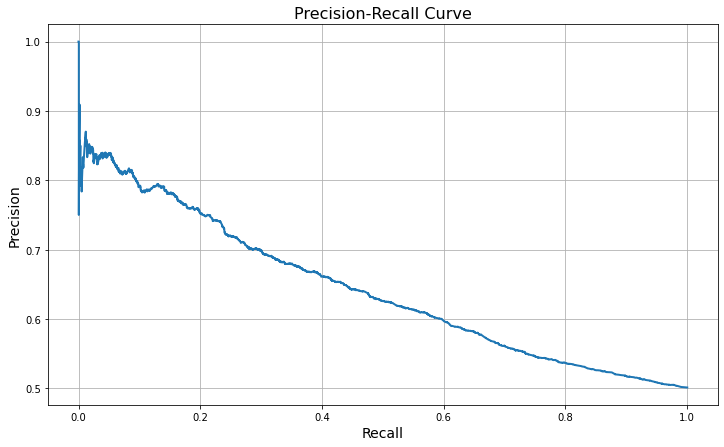

In [193]:
probas = model_RF.predict_proba(X_test_transformed)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, probas)

#plt.plot(precision, recall)

plt.figure(figsize=(12, 7))

plt.plot(recall, precision, linewidth=2)
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.grid(True)
#plt.legend()

plt.show()

Поскольку критерием качества выступает площадь под PR-кривой, можно сказать, что модель не дотягивает до уровня внедрения.

In [204]:
#feature_imp = pd.Series(model_RF.feature_importances_, index=model_RF.fea).sort_values(ascending=False)

#model_RF.feature_importances_.shape

ohe_features

(103,)

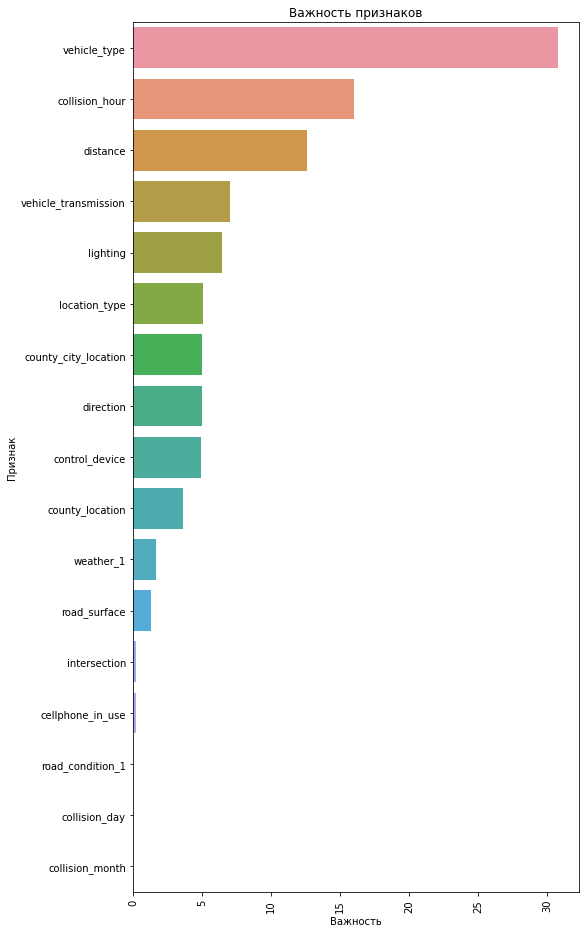

In [100]:
plt.figure(figsize=(8, 16))

sns.barplot(y=list(feature_imp.index), x=feature_imp.values, orient='h')

plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.xticks(rotation= 90)

plt.show()


Как видно из графика, наиболее важные факторы - это тип кузова (`vehicle_type`), время (`collision_hour`)  и расстояниt от главной дороги (`distance`).

Посмотрим зависимость целевой переменной от каждого из них.

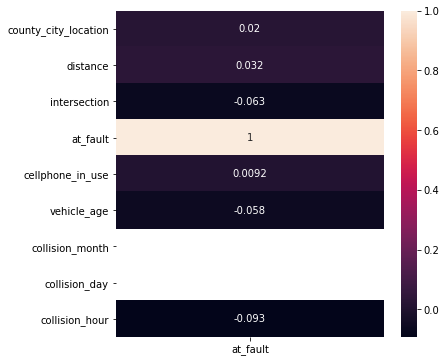

In [101]:
plt.figure(figsize=(6, 6))

sns.heatmap(data_for_model.corr()[['at_fault']], annot = True)
plt.show()

interval columns not set, guessing: ['county_city_location', 'distance', 'intersection', 'at_fault', 'cellphone_in_use', 'vehicle_age', 'collision_month', 'collision_day', 'collision_hour']


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable collision_month for analysis 1. Dropping this column
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable collision_day for analysis 1. Dropping this column
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable collision_date for analysis 1. Dropping this column
  warnings.warn(


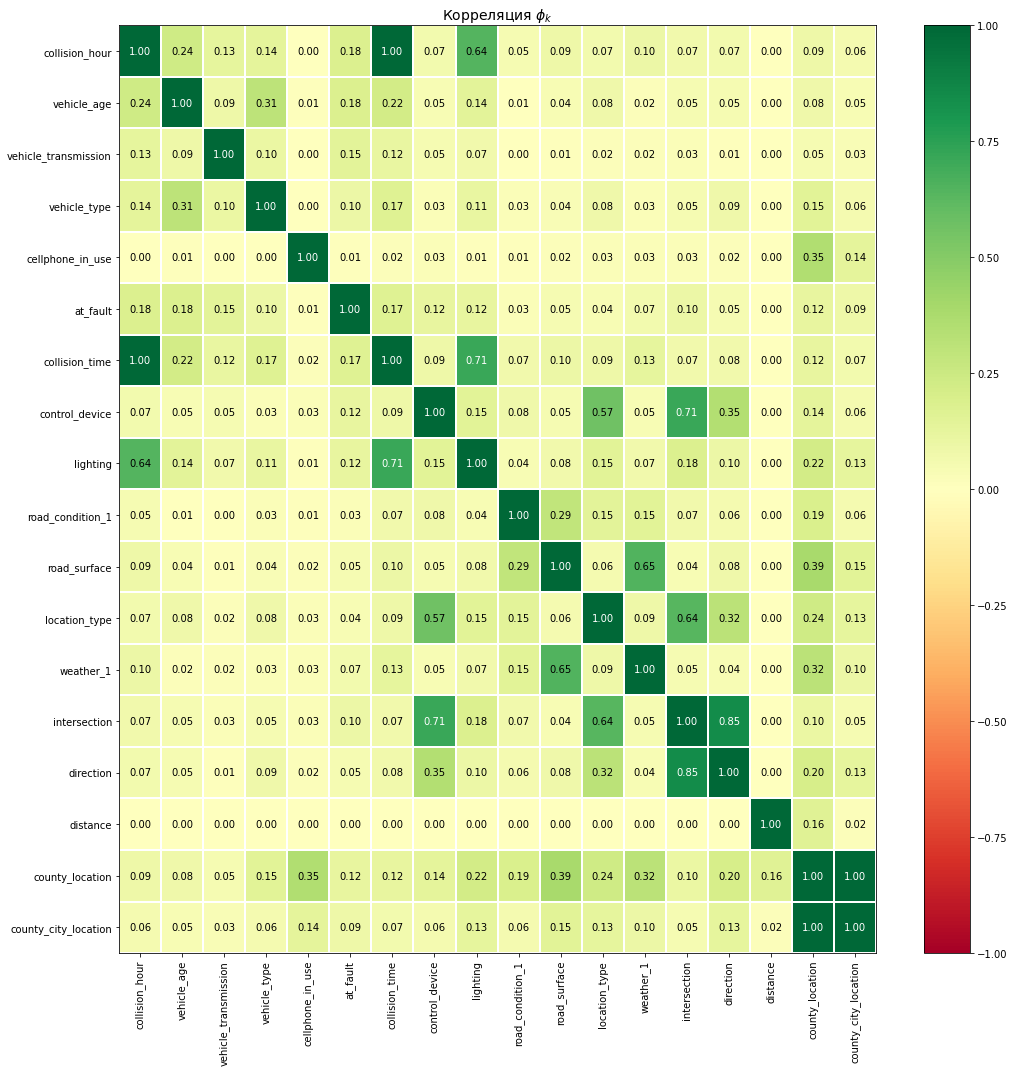

In [102]:
phik_corr = data_for_model.phik_matrix()

plot_correlation_matrix(
    phik_corr.values,
    x_labels=phik_corr.columns,
    y_labels=phik_corr.index,
    title='Корреляция $\phi_k$',
    identity_layout=True,
    figsize=(15, 15)
)


Как видно из графика, зависимости факторов и целевой переменной находжятся в пределах 0,10—0,18.

Предложите, чем можно оборудовать автомобиль, чтобы учесть этот фактор во время посадки водителя.
1. `collision_hour` Здесь можно предложить: 
* автоматический свет (хорошая освещенность снизит шанс аварии);
* ограничитель скорости при потенциально опасном маршруте.
2. `vehicle_type` Здесь можно предложить: 
* делать скидку на другие типы кузова (либо наоборот, повышать цену аренды седанов и купе).
3. `county_location` Здесь можно предложить: 
* ограничитель скорости при потенциально опасном маршруте.

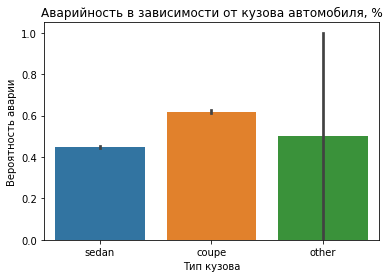

In [103]:
sns.barplot(data=data_for_model, x='vehicle_type', y='at_fault')
plt.title('Аварийность в зависимости от кузова автомобиля, %')
plt.xlabel('Тип кузова')
plt.ylabel('Вероятность аварии')

plt.show()

In [104]:
# И в цифрах
data_for_model.groupby('vehicle_type')['at_fault'].agg('mean')

vehicle_type
coupe    0.617776
other    0.500000
sedan    0.447649
Name: at_fault, dtype: float64

In [105]:
data_for_model['vehicle_type'].value_counts()

sedan    37029
coupe    18947
other        4
Name: vehicle_type, dtype: int64

Из графика видим, что купе становятся виновниками аварий почти в полтора раза чаще седанов.

Другие типы кузова (`other`) можно не учитывать ввиду их крайне малого количества.

## Выводы

Задача: создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.

Для решения задачи по исходным данных создана выборка для последующего создания модели машинного обучения.

Проведен небольшой исследовательский анализ данных, коллегам поставлены задачи по дополнительному исследованию данных.

Выборка подготовлена для эффективной работы модели: удалены явные дубликаты и неадекватные значения, различными методами заполнены пропуски в данных.

Созданы обучающая и тестовая выборки.

Разработан пайплайн для кодирования и масштабирования данных.

Обучены три модели: логистическая регрессия, случайный лес и CatBoost. Выбрана метрика для оценки качества модели - F1-мера.

Лучший результаты показала модель CatBoost с результатом 0,5952.

При текущих данных точность модели недостаточна для запуска.

Возможно, улучшить прогноз могли бы данные:
* непосредственно о водителе (возраст, пол, стаж, семейное положение etc);
* более подробные данные по автомобилям (бренд, марка, мощность etc);
* взять более широкий временной диапазон (возможно, данных за год недостаточно).

Оценена важность признаков. Наиболее важными оказались тип кузова автомобиля, время (часы) и дистанция от главной дороги.